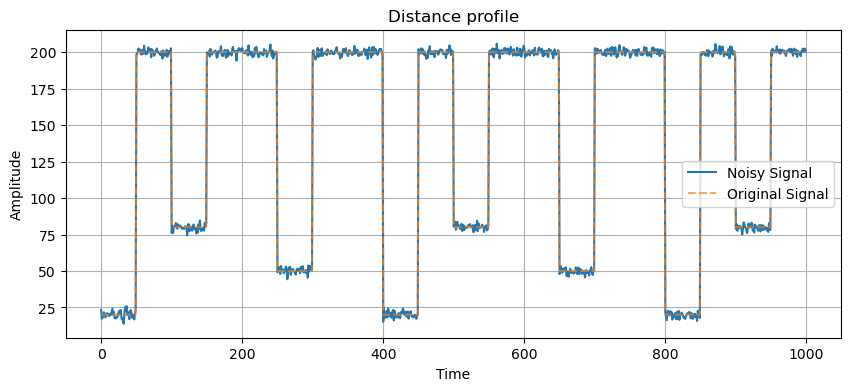

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
total_points = 1000  # Total number of data points
noise_std = 2        # Standard deviation of the noise
signal_level = 200   # Constant value of the signal
branch_positions = [0, 100, 250, 400, 500, 650, 800, 900]  # Positions where the branches occur
branch_heights = [20, 80, 50, 20, 80, 50, 20, 80]          # Heights of the branches
branch_width = 50    # Width of the branch

# Generate the square wave signal
signal = np.full(total_points, signal_level)

for pos, height in zip(branch_positions, branch_heights):
    signal[pos:pos+branch_width] = height

# Add normally distributed noise
noise = np.random.normal(0, noise_std, total_points)
noisy_signal = signal + noise

# Plot the signal
plt.figure(figsize=(10, 4))
plt.plot(noisy_signal, label='Noisy Signal')
plt.plot(signal, linestyle='--', label='Original Signal', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Distance profile')
plt.legend()
plt.grid(True)
plt.show()

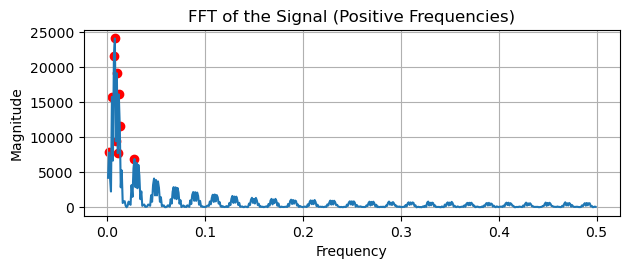

Frequency: 0.0280, Magnitude: 6909.351
Frequency: 0.0110, Magnitude: 7730.171
Frequency: 0.0020, Magnitude: 7835.706
Frequency: 0.0090, Magnitude: 9437.079
Frequency: 0.0130, Magnitude: 11568.580
Frequency: 0.0050, Magnitude: 15766.142
Frequency: 0.0120, Magnitude: 16119.942
Frequency: 0.0100, Magnitude: 19145.854
Frequency: 0.0070, Magnitude: 21637.784
Frequency: 0.0080, Magnitude: 24121.263
Estimated Period: 125.00


In [16]:
n_dominant_frequencies = 10  # Number of dominant frequencies to find

# Perform FFT
fft_result = np.fft.fft(noisy_signal)
frequencies = np.fft.fftfreq(total_points)

# Get the magnitude of the FFT result
fft_magnitude = np.abs(fft_result)

# Consider only the positive frequencies
positive_freq_indices = frequencies > 0
positive_frequencies = frequencies[positive_freq_indices]
positive_magnitudes = fft_magnitude[positive_freq_indices]

# Find the indices of the n most dominant positive frequencies
dominant_indices = np.argsort(positive_magnitudes)[-n_dominant_frequencies:]
dominant_frequencies = positive_frequencies[dominant_indices]
dominant_magnitudes = positive_magnitudes[dominant_indices]

# Plot the FFT magnitude for positive frequencies
plt.subplot(2, 1, 2)
plt.plot(positive_frequencies, positive_magnitudes)
plt.scatter(dominant_frequencies, dominant_magnitudes, color='red')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('FFT of the Signal (Positive Frequencies)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the dominant positive frequencies and their magnitudes
for freq, mag in zip(dominant_frequencies, dominant_magnitudes):
    print(f"Frequency: {freq:.4f}, Magnitude: {mag:.3f}")

# Estimated period is the reciprocal of the dominant frequency
estimated_period = 1 / dominant_frequencies[-1]
print(f"Estimated Period: {estimated_period:.2f}")

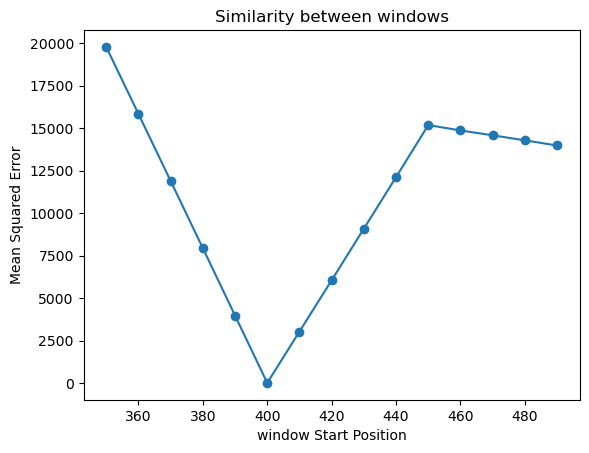

Estimated Period: 400


In [17]:
window_length = 350  # Hypothesized period length
window_incr   = 10   # Hypothesized period length
window_max    = 500  # Hypothesized period length

def compute_similarity(window1, window2):
    # Compute mse. Lower value means more similar
    return np.mean((window1 - window2) ** 2)

# Compare windows to detect repetition
similarities = []
first_window = noisy_signal[:window_length]

for start in range(window_length, window_max, window_incr):
    end = start + window_length
    if end > total_points:
        break
    current_window = noisy_signal[start:end]
    similarity = compute_similarity(first_window, current_window)  # Compute similarity (mse - scalar value)
    similarities.append(similarity)

# Plot the similarities
x_values = range(window_length, window_max, window_incr)#[:-1]  # Remove the last value
plt.plot(x_values, similarities, marker='o')
plt.title('Similarity between windows')
plt.xlabel('window Start Position')
plt.ylabel('Mean Squared Error')
plt.show()

# Identify the minimum similarity (indicating repetition)
min_similarity_idx = np.argmin(similarities)
estimated_period = x_values[min_similarity_idx]
print(f'Estimated Period: {estimated_period}')